In [199]:
from bayesian_model import GPSparseBayesModel
from data_loader import data_loader
from utils import ause, return_replicates
from utils import permutation_test_ause, expected_calibration_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
import seaborn as sns

In [26]:
datasets = data_loader()

In [138]:
def run_simulation(dataset, kernel, loss, ind):
    X, y = datasets[dataset]
    replicates = return_replicates(X, y)
    for X_train, X_test, y_train, y_test in replicates:
        model = GPSparseBayesModel(**{"random_seed": 7200, 
                                      "induced_points_method": "random", 
                                      "num_induced_samples": 'sqrt', 
                                      "kernel": kernel,
                                      "loss": loss,
                                      "induced_points_method": ind
                                    })
        model.after_setup()
        X_train, X_test = np.array(X_train), np.array(X_test)
        y_train, y_test = np.array(y_train).ravel(), np.array(y_test).ravel()
        model.train(X_train, y_train)
        pred_probs, pred_var, pred_labels = model.test(X_test, None)
        accuracy = accuracy_score(y_test, np.where(pred_probs > 0.5, 1, 0))
        f1 = f1_score(y_test, np.where(pred_probs > 0.5, 1, 0))
        pred_ause = ause(pred_probs, pred_var, pred_labels)[0]
        pred_probs_t = np.reshape(pred_probs, (-1,1))
        pred_ece = expected_calibration_error(y_test, 
                                              np.concatenate((1-pred_probs_t, pred_probs_t), axis=1), num_bins=10)[0]
        results['dataset'].append(dataset)
        results['kernel'].append(kernel)
        results['loss'].append(loss)
        results['induction_method'].append(ind)
        results['ause'].append(pred_ause)
        results['ece'].append(pred_ece)
        results['accuracy'].append(accuracy)
        results['f1'].append(f1)
        print(pred_ause, pred_ece, accuracy, f1, ind, kernel, loss, dataset)

In [173]:
from sklearn.model_selection import train_test_split

def run_simulation_no_replicates(dataset, kernel, loss, ind):
    X, y = datasets[dataset]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=7200)
    model = GPSparseBayesModel(**{"random_seed": 7200, 
                                  "induced_points_method": "random", 
                                  "num_induced_samples": 'sqrt', 
                                  "kernel": kernel,
                                  "loss": loss,
                                  "induced_points_method": ind
                                })
    model.after_setup()
    X_train, X_test = np.array(X_train), np.array(X_test)
    y_train, y_test = np.array(y_train).ravel(), np.array(y_test).ravel()
    model.train(X_train, y_train)
    pred_probs, pred_var, pred_labels = model.test(X_test, None)
    accuracy = accuracy_score(y_test, np.where(pred_probs > 0.5, 1, 0))
    f1 = f1_score(y_test, np.where(pred_probs > 0.5, 1, 0))
    pred_ause = ause(pred_probs, pred_var, pred_labels)[0]
    pred_probs_t = np.reshape(pred_probs, (-1,1))
    pred_ece = expected_calibration_error(y_test, 
                                          np.concatenate((1-pred_probs_t, pred_probs_t), axis=1), num_bins=10)[0]
    results_nr['dataset'].append(dataset)
    results_nr['kernel'].append(kernel)
    results_nr['loss'].append(loss)
    results_nr['induction_method'].append(ind)
    results_nr['ause'].append(pred_ause)
    results_nr['ece'].append(pred_ece)
    results_nr['accuracy'].append(accuracy)
    results_nr['f1'].append(f1)
    print(pred_ause, pred_ece, accuracy, f1, ind, kernel, loss, dataset)

In [143]:
kernels = ['rbf', 'linear', 'poly']
losses = ['trace_elbo', 'trace_meanfield_elbo']
induced_points_methods = ['kmeans', 'random']
dataset_names = list(datasets.keys())

results = {
    'dataset': [],
    'kernel': [],
    'induction_method': [],
    'loss': [],
    'ause': [],
    'ece': [],
    'accuracy': [],
    'f1': []
}

for dataset, kernel, loss, ind in itertools.product(dataset_names, kernels, losses, induced_points_methods):
    run_simulation(dataset, kernel, loss, ind)

0.1472797880990551 0.11006175825243773 0.6458333333333334 0.45161290322580644 kmeans rbf trace_elbo diabetes
0.0 0.15624999999999822 0.65625 0.0 kmeans rbf trace_elbo diabetes
0.0034677092943573304 0.10331515445313977 0.6041666666666666 0.5476190476190477 random rbf trace_elbo diabetes
2.9422737677231573e-06 0.17708290969640914 0.6770833333333334 0.1142857142857143 random rbf trace_elbo diabetes
0.0 0.15624999999999867 0.65625 0.0 kmeans rbf trace_meanfield_elbo diabetes
1.932898285872397e-15 0.15625000035762945 0.34375 0.5116279069767442 kmeans rbf trace_meanfield_elbo diabetes
0.10115605010881032 0.04086941788171564 0.7395833333333334 0.5614035087719297 random rbf trace_meanfield_elbo diabetes
0.1832529393801265 0.13031517463405135 0.6666666666666666 0.4666666666666667 random rbf trace_meanfield_elbo diabetes
0.004746029439934126 0.19429364697203735 0.6979166666666666 0.5538461538461539 kmeans linear trace_elbo diabetes
0.00226833868587305 0.09180130959926079 0.59375 0.49350649350649

0.5185420341205088 0.03975269104020892 0.7944535073409462 0.20253164556962025 random rbf trace_elbo white-wine
0.5289530606822934 0.02098616979029073 0.7830342577487766 0.19393939393939394 kmeans rbf trace_meanfield_elbo white-wine
0.37550369891021484 0.019939023504399755 0.8172920065252854 0.36363636363636365 kmeans rbf trace_meanfield_elbo white-wine
0.44656155197681874 0.03512236781846254 0.7895595432300163 0.178343949044586 random rbf trace_meanfield_elbo white-wine
0.47403470427302696 0.0277011114783417 0.8058727569331158 0.24203821656050953 random rbf trace_meanfield_elbo white-wine
0.0046093059017404785 0.029388208810048697 0.4730831973898858 0.2024691358024691 kmeans linear trace_elbo white-wine
0.004098140901875826 0.0915623220301592 0.5938009787928222 0.32152588555858314 kmeans linear trace_elbo white-wine
0.002918765175661222 0.038445173829422655 0.5399673735725938 0.32211538461538464 random linear trace_elbo white-wine
0.0030998550609941016 0.14909655605128466 0.65089722675

In [208]:
simulation_runs = pd.DataFrame.from_dict(results)
simulation_runs.to_csv('simulation_runs.csv')

In [209]:
from scipy.stats import t, f, sem
from bioinfokit.analys import stat
import statsmodels.api as sm
from statsmodels.formula.api import ols

diabetes = simulation_runs.loc[simulation_runs['dataset']=='diabetes']
ionosphere = simulation_runs.loc[simulation_runs['dataset']=='ionosphere']
red_wine = simulation_runs.loc[simulation_runs['dataset']=='red-wine']
white_wine = simulation_runs.loc[simulation_runs['dataset']=='white-wine']

diabetes['v1'] = diabetes['accuracy']+(1-diabetes['ause'])
ionosphere['v1'] = ionosphere['accuracy']+(1-ionosphere['ause'])
red_wine['v1'] = red_wine['accuracy']+(1-red_wine['ause'])
white_wine['v1'] = white_wine['accuracy']+(1-white_wine['ause'])

C:\Users\divya\anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\divya\anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\divya\anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

Diabetes

In [210]:
diabetes_model = ols('v1~C(kernel)+C(loss)+C(induction_method)+C(kernel)*C(loss)*C(induction_method)', data=diabetes).fit()
sm.stats.anova_lm(diabetes_model)

,df,sum_sq,mean_sq,F,PR(>F)
C(kernel),2.0,0.006531,0.003266,0.318730,0.733042
C(loss),1.0,0.016957,0.016957,1.655027,0.222542
C(induction_method),1.0,0.002404,0.002404,0.234651,0.636817
C(kernel):C(loss),2.0,0.052106,0.026053,2.542724,0.120041
C(kernel):C(induction_method),2.0,0.029522,0.014761,1.440647,0.274943
C(loss):C(induction_method),1.0,0.004277,0.004277,0.417438,0.530380
C(kernel):C(loss):C(induction_method),2.0,0.003965,0.001983,0.193503,0.826589
Residual,12.0,0.122952,0.010246,NaN,NaN


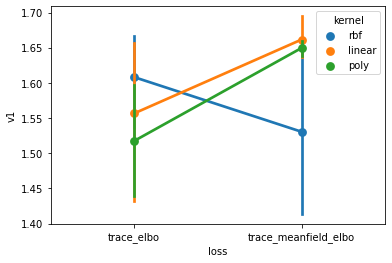

In [214]:
sns.pointplot(x='loss', y='v1', hue='kernel', data=diabetes)

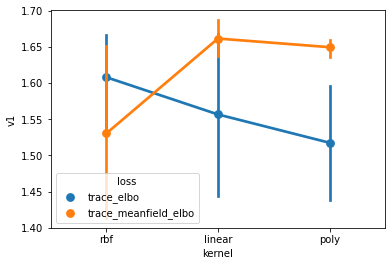

In [226]:
sns.pointplot(x='kernel', y='v1', hue='loss', data=diabetes)

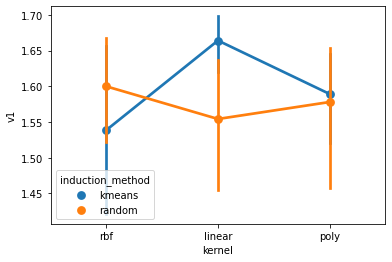

In [227]:
sns.pointplot(x='kernel', y='v1', hue='induction_method', data=diabetes)

In [235]:
res = stat()
res.tukey_hsd(phalpha=0.05, df=diabetes, 
              res_var='v1', xfac_var=['loss', 'kernel', 'induction_method'], 
              anova_model='v1~C(kernel)+C(loss)+C(induction_method)+C(kernel)*C(loss)*C(induction_method)')
res.tukey_summary.sort_values(by='p-value')

,group1,group2,Diff,Lower,Upper,q-value,p-value
34,"(trace_elbo, linear, random)","(trace_meanfield_elbo, linear, kmeans)",0.214917,-0.186948,0.616781,3.002671,0.608472
52,"(trace_meanfield_elbo, rbf, kmeans)","(trace_meanfield_elbo, linear, kmeans)",0.186000,-0.215865,0.587865,2.598668,0.752150
47,"(trace_elbo, poly, random)","(trace_meanfield_elbo, linear, kmeans)",0.183673,-0.218191,0.585538,2.566159,0.763711
37,"(trace_elbo, linear, random)","(trace_meanfield_elbo, poly, random)",0.182540,-0.219325,0.584404,2.550322,0.769341
36,"(trace_elbo, linear, random)","(trace_meanfield_elbo, poly, kmeans)",0.174756,-0.227108,0.576621,2.441579,0.808014
...,...,...,...,...,...,...,...
29,"(trace_elbo, linear, kmeans)","(trace_meanfield_elbo, poly, random)",0.011297,-0.390568,0.413162,0.157833,0.900000
30,"(trace_elbo, linear, random)","(trace_elbo, poly, kmeans)",0.061639,-0.340226,0.463504,0.861179,0.900000
31,"(trace_elbo, linear, random)","(trace_elbo, poly, random)",0.031243,-0.370621,0.433108,0.436513,0.900000
33,"(trace_elbo, linear, random)","(trace_meanfield_elbo, rbf, random)",0.089837,-0.312027,0.491702,1.255144,0.900000


In [242]:
res = stat()
res.tukey_hsd(phalpha=0.05, df=diabetes, 
              res_var='v1', xfac_var=['loss', 'kernel', 'induction_method'], 
              anova_model='v1~C(kernel)+C(loss)+C(induction_method)+C(kernel)*C(loss)*C(induction_method)')
res.tukey_summary.sort_values(by='Diff', ascending=False)

,group1,group2,Diff,Lower,Upper,q-value,p-value
34,"(trace_elbo, linear, random)","(trace_meanfield_elbo, linear, kmeans)",0.214917,-0.186948,0.616781,3.002671,0.608472
52,"(trace_meanfield_elbo, rbf, kmeans)","(trace_meanfield_elbo, linear, kmeans)",0.186000,-0.215865,0.587865,2.598668,0.752150
47,"(trace_elbo, poly, random)","(trace_meanfield_elbo, linear, kmeans)",0.183673,-0.218191,0.585538,2.566159,0.763711
37,"(trace_elbo, linear, random)","(trace_meanfield_elbo, poly, random)",0.182540,-0.219325,0.584404,2.550322,0.769341
36,"(trace_elbo, linear, random)","(trace_meanfield_elbo, poly, kmeans)",0.174756,-0.227108,0.576621,2.441579,0.808014
...,...,...,...,...,...,...,...
27,"(trace_elbo, linear, kmeans)","(trace_meanfield_elbo, linear, random)",0.004985,-0.396879,0.406850,0.069651,0.900000
28,"(trace_elbo, linear, kmeans)","(trace_meanfield_elbo, poly, kmeans)",0.003514,-0.398351,0.405378,0.049091,0.900000
11,"(trace_elbo, rbf, random)","(trace_elbo, linear, kmeans)",0.003436,-0.398428,0.405301,0.048012,0.900000
45,"(trace_elbo, poly, random)","(trace_meanfield_elbo, rbf, kmeans)",0.002327,-0.399538,0.404191,0.032509,0.900000


Ionosphere

In [215]:
ionosphere_model = ols('v1~C(kernel)+C(loss)+C(induction_method)+C(kernel)*C(loss)*C(induction_method)', data=ionosphere).fit()
sm.stats.anova_lm(ionosphere_model)

,df,sum_sq,mean_sq,F,PR(>F)
C(kernel),2.0,0.072594,0.036297,11.037276,0.001908
C(loss),1.0,0.001014,0.001014,0.308262,0.588949
C(induction_method),1.0,0.000408,0.000408,0.124081,0.730759
C(kernel):C(loss),2.0,0.012812,0.006406,1.947928,0.185090
C(kernel):C(induction_method),2.0,0.004118,0.002059,0.626091,0.551268
C(loss):C(induction_method),1.0,0.000925,0.000925,0.281344,0.605498
C(kernel):C(loss):C(induction_method),2.0,0.001309,0.000654,0.199019,0.822185
Residual,12.0,0.039463,0.003289,NaN,NaN


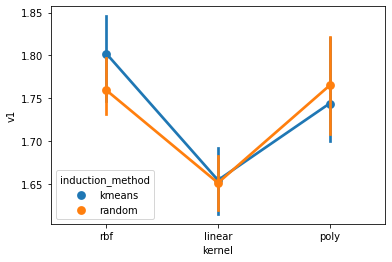

In [219]:
sns.pointplot(x='kernel', y='v1', hue='induction_method', data=ionosphere)

In [236]:
res = stat()
res.tukey_hsd(phalpha=0.05, df=ionosphere, 
              res_var='v1', xfac_var=['loss', 'kernel', 'induction_method'], 
              anova_model='v1~C(kernel)+C(loss)+C(induction_method)+C(kernel)*C(loss)*C(induction_method)')
res.tukey_summary.sort_values(by='p-value')

,group1,group2,Diff,Lower,Upper,q-value,p-value
1,"(trace_elbo, rbf, kmeans)","(trace_elbo, linear, kmeans)",0.205668,-0.022004,0.433339,5.071953,0.090955
2,"(trace_elbo, rbf, kmeans)","(trace_elbo, linear, random)",0.200729,-0.026943,0.428400,4.950152,0.103962
22,"(trace_elbo, linear, kmeans)","(trace_elbo, poly, kmeans)",0.158740,-0.068931,0.386411,3.914667,0.298727
8,"(trace_elbo, rbf, kmeans)","(trace_meanfield_elbo, linear, random)",0.157042,-0.070630,0.384713,3.872790,0.310467
30,"(trace_elbo, linear, random)","(trace_elbo, poly, kmeans)",0.153801,-0.073870,0.381472,3.792867,0.333967
...,...,...,...,...,...,...,...
35,"(trace_elbo, linear, random)","(trace_meanfield_elbo, linear, random)",0.043687,-0.183984,0.271358,1.077362,0.900000
36,"(trace_elbo, linear, random)","(trace_meanfield_elbo, poly, kmeans)",0.074656,-0.153015,0.302327,1.841083,0.900000
38,"(trace_elbo, poly, kmeans)","(trace_elbo, poly, random)",0.005197,-0.222474,0.232868,0.128165,0.900000
40,"(trace_elbo, poly, kmeans)","(trace_meanfield_elbo, rbf, random)",0.033438,-0.194234,0.261109,0.824604,0.900000


Red Wine

In [220]:
red_wine_model = ols('v1~C(kernel)+C(loss)+C(induction_method)+C(kernel)*C(loss)*C(induction_method)', data=red_wine).fit()
sm.stats.anova_lm(red_wine_model)

,df,sum_sq,mean_sq,F,PR(>F)
C(kernel),2.0,0.370759,0.185379,128.545707,7.864814e-09
C(loss),1.0,0.021310,0.021310,14.777007,2.335079e-03
C(induction_method),1.0,0.008747,0.008747,6.065591,2.988260e-02
C(kernel):C(loss),2.0,0.050358,0.025179,17.459622,2.798862e-04
C(kernel):C(induction_method),2.0,0.011166,0.005583,3.871337,5.042567e-02
C(loss):C(induction_method),1.0,0.000163,0.000163,0.113337,7.421910e-01
C(kernel):C(loss):C(induction_method),2.0,0.001818,0.000909,0.630400,5.491224e-01
Residual,12.0,0.017306,0.001442,NaN,NaN


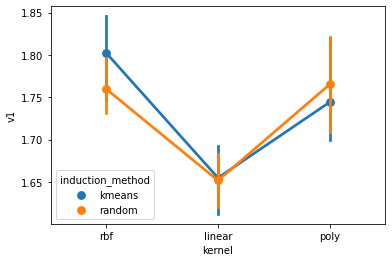

In [221]:
sns.pointplot(x='kernel', y='v1', hue='induction_method', data=ionosphere)

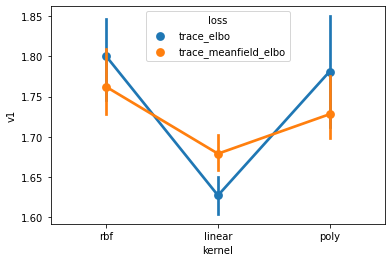

In [222]:
sns.pointplot(x='kernel', y='v1', hue='loss', data=ionosphere)

In [234]:
res = stat()
res.tukey_hsd(phalpha=0.05, df=red_wine, 
              res_var='v1', xfac_var=['loss', 'kernel', 'induction_method'], 
              anova_model='v1~C(kernel)+C(loss)+C(induction_method)+C(kernel)*C(loss)*C(induction_method)')
res.tukey_summary.sort_values(by='p-value')

,group1,group2,Diff,Lower,Upper,q-value,p-value
32,"(trace_elbo, linear, random)","(trace_meanfield_elbo, rbf, kmeans)",0.303584,0.152818,0.454350,11.305558,0.001
55,"(trace_meanfield_elbo, rbf, kmeans)","(trace_meanfield_elbo, poly, random)",0.362937,0.212171,0.513704,13.515885,0.001
25,"(trace_elbo, linear, kmeans)","(trace_meanfield_elbo, rbf, random)",0.283900,0.133134,0.434667,10.572531,0.001
18,"(trace_elbo, rbf, random)","(trace_meanfield_elbo, linear, random)",0.261616,0.110850,0.412382,9.742652,0.001
17,"(trace_elbo, rbf, random)","(trace_meanfield_elbo, linear, kmeans)",0.266299,0.115533,0.417066,9.917059,0.001
...,...,...,...,...,...,...,...
64,"(trace_meanfield_elbo, linear, random)","(trace_meanfield_elbo, poly, random)",0.025147,-0.125619,0.175914,0.936493,0.900
62,"(trace_meanfield_elbo, linear, kmeans)","(trace_meanfield_elbo, poly, random)",0.029831,-0.120936,0.180597,1.110900,0.900
36,"(trace_elbo, linear, random)","(trace_meanfield_elbo, poly, kmeans)",0.016349,-0.134417,0.167116,0.608850,0.900
28,"(trace_elbo, linear, kmeans)","(trace_meanfield_elbo, poly, kmeans)",0.024536,-0.126231,0.175302,0.913715,0.900


In [240]:
res = stat()
res.tukey_hsd(phalpha=0.05, df=red_wine, 
              res_var='v1', xfac_var=['loss', 'kernel', 'induction_method'], 
              anova_model='v1~C(kernel)+C(loss)+C(induction_method)+C(kernel)*C(loss)*C(induction_method)')
res.tukey_summary.sort_values(by='q-value', ascending=False)

,group1,group2,Diff,Lower,Upper,q-value,p-value
52,"(trace_meanfield_elbo, rbf, kmeans)","(trace_meanfield_elbo, linear, kmeans)",0.392768,0.242002,0.543534,14.626785,0.001
53,"(trace_meanfield_elbo, rbf, kmeans)","(trace_meanfield_elbo, linear, random)",0.388085,0.237318,0.538851,14.452379,0.001
55,"(trace_meanfield_elbo, rbf, kmeans)","(trace_meanfield_elbo, poly, random)",0.362937,0.212171,0.513704,13.515885,0.001
7,"(trace_elbo, rbf, kmeans)","(trace_meanfield_elbo, linear, kmeans)",0.346961,0.196195,0.497727,12.920919,0.001
24,"(trace_elbo, linear, kmeans)","(trace_meanfield_elbo, rbf, kmeans)",0.344469,0.193703,0.495235,12.828124,0.001
...,...,...,...,...,...,...,...
29,"(trace_elbo, linear, kmeans)","(trace_meanfield_elbo, poly, random)",0.018468,-0.132298,0.169235,0.687761,0.900
36,"(trace_elbo, linear, random)","(trace_meanfield_elbo, poly, kmeans)",0.016349,-0.134417,0.167116,0.608850,0.900
6,"(trace_elbo, rbf, kmeans)","(trace_meanfield_elbo, rbf, random)",0.014762,-0.136005,0.165528,0.549727,0.900
60,"(trace_meanfield_elbo, linear, kmeans)","(trace_meanfield_elbo, linear, random)",0.004683,-0.146083,0.155450,0.174406,0.900


White wine

In [223]:
white_wine_model = ols('v1~C(kernel)+C(loss)+C(kernel)*C(loss)', data=white_wine).fit()
sm.stats.anova_lm(white_wine_model)

,df,sum_sq,mean_sq,F,PR(>F)
C(kernel),2.0,0.478984,0.239492,68.725680,3.741983e-09
C(loss),1.0,0.134875,0.134875,38.704169,7.186244e-06
C(kernel):C(loss),2.0,0.085718,0.042859,12.299036,4.294801e-04
Residual,18.0,0.062726,0.003485,NaN,NaN


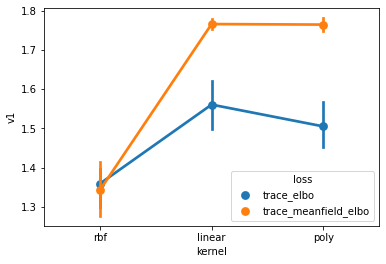

In [224]:
sns.pointplot(x='kernel', y='v1', hue='loss', data=white_wine)

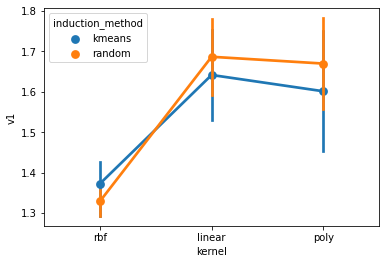

In [225]:
sns.pointplot(x='kernel', y='v1', hue='induction_method', data=white_wine)

In [238]:
res = stat()
res.tukey_hsd(phalpha=0.05, df=white_wine, 
              res_var='v1', xfac_var=['loss', 'kernel', 'induction_method'], 
              anova_model='v1~C(kernel)+C(loss)+C(induction_method)+C(kernel)*C(loss)*C(induction_method)')
res.tukey_summary.sort_values(by='p-value')

,group1,group2,Diff,Lower,Upper,q-value,p-value
52,"(trace_meanfield_elbo, rbf, kmeans)","(trace_meanfield_elbo, linear, kmeans)",0.405331,0.175890,0.634772,9.918727,0.001
58,"(trace_meanfield_elbo, rbf, random)","(trace_meanfield_elbo, poly, kmeans)",0.411591,0.182149,0.641032,10.071898,0.001
20,"(trace_elbo, rbf, random)","(trace_meanfield_elbo, poly, random)",0.460824,0.231382,0.690265,11.276664,0.001
19,"(trace_elbo, rbf, random)","(trace_meanfield_elbo, poly, kmeans)",0.428371,0.198930,0.657812,10.482523,0.001
18,"(trace_elbo, rbf, random)","(trace_meanfield_elbo, linear, random)",0.459305,0.229863,0.688746,11.239491,0.001
...,...,...,...,...,...,...,...
6,"(trace_elbo, rbf, kmeans)","(trace_meanfield_elbo, rbf, random)",0.059647,-0.169794,0.289089,1.459612,0.900
5,"(trace_elbo, rbf, kmeans)","(trace_meanfield_elbo, rbf, kmeans)",0.049131,-0.180311,0.278572,1.202261,0.900
3,"(trace_elbo, rbf, kmeans)","(trace_elbo, poly, kmeans)",0.055806,-0.173635,0.285247,1.365615,0.900
51,"(trace_meanfield_elbo, rbf, kmeans)","(trace_meanfield_elbo, rbf, random)",0.010517,-0.218925,0.239958,0.257351,0.900


In [239]:
res.tukey_summary.sort_values(by='q-value', ascending=False)

,group1,group2,Diff,Lower,Upper,q-value,p-value
20,"(trace_elbo, rbf, random)","(trace_meanfield_elbo, poly, random)",0.460824,0.231382,0.690265,11.276664,0.001
18,"(trace_elbo, rbf, random)","(trace_meanfield_elbo, linear, random)",0.459305,0.229863,0.688746,11.239491,0.001
59,"(trace_meanfield_elbo, rbf, random)","(trace_meanfield_elbo, poly, random)",0.444043,0.214602,0.673485,10.866040,0.001
57,"(trace_meanfield_elbo, rbf, random)","(trace_meanfield_elbo, linear, random)",0.442524,0.213083,0.671966,10.828867,0.001
55,"(trace_meanfield_elbo, rbf, kmeans)","(trace_meanfield_elbo, poly, random)",0.433527,0.204085,0.662968,10.608688,0.001
...,...,...,...,...,...,...,...
60,"(trace_meanfield_elbo, linear, kmeans)","(trace_meanfield_elbo, linear, random)",0.026676,-0.202765,0.256118,0.652789,0.900
16,"(trace_elbo, rbf, random)","(trace_meanfield_elbo, rbf, random)",0.016780,-0.212661,0.246221,0.410624,0.900
51,"(trace_meanfield_elbo, rbf, kmeans)","(trace_meanfield_elbo, rbf, random)",0.010517,-0.218925,0.239958,0.257351,0.900
61,"(trace_meanfield_elbo, linear, kmeans)","(trace_meanfield_elbo, poly, kmeans)",0.004257,-0.225184,0.233699,0.104180,0.900


#### Special case for aleatoric uncertainty

In [86]:
data3 = pd.read_csv('data/winequality-red.csv', sep=";")
data3['label'] = data3['quality'] > 5
data3['label'] = data3['label'].astype(int)

In [166]:
X, y = data3[data3.columns[:-2]], data3['label']

model = GPSparseBayesModel()
model.after_setup()
model.train(np.array(X), np.array(y).ravel())

In [96]:
pred_probs, pred_variances, pred_labels = model.test(np.array(X), None)

In [111]:
pred_probs_T = np.reshape(pred_probs, (-1,1))
pred_probs_c = 1 - pred_probs_T
probs = np.concatenate([pred_probs_T, 1-pred_probs_T], axis=1)

In [137]:
def ece_score(py, y_test, n_bins=10):
    py = np.array(py)
    y_test = np.array(y_test)
    if y_test.ndim > 1:
        y_test = np.argmax(y_test, axis=1)
    py_index = np.argmax(py, axis=1)
    py_value = []
    for i in range(py.shape[0]):
        py_value.append(py[i, py_index[i]])
    py_value = np.array(py_value)
    acc, conf = np.zeros(n_bins), np.zeros(n_bins)
    Bm = np.zeros(n_bins)
    for m in range(n_bins):
        a, b = m / n_bins, (m + 1) / n_bins
        for i in range(py.shape[0]):
            if py_value[i] > a and py_value[i] <= b:
                Bm[m] += 1
                if py_index[i] == y_test[i]:
                    acc[m] += 1
                conf[m] += py_value[i]
        if Bm[m] != 0:
            acc[m] = acc[m] / Bm[m]
            conf[m] = conf[m] / Bm[m]
    ece = 0
    for m in range(n_bins):
        ece += Bm[m] * np.abs((acc[m] - conf[m]))
    return ece / sum(Bm)

ece_score(probs, y)

0.43433208135401985